In [1]:
import numpy as np
import pandas as pd
# %matplotlib qt
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import modelbase
from modelbase.ode import Simulator

from scipy import integrate

plt.style.use("./notebook.mplstyle")
print(modelbase.__version__)

1.3.5


In [2]:
%%capture
cd ..

In [3]:
from models import get_model


m = get_model()

par_orig = m.get_parameters()

def get_new_y0(s):
    return dict(s.get_results_df().iloc[-1])

In [4]:
y0 = {
    "PQ": 11.027139850905353,
    "PC": 1.8895071932002812,
    "Fd": 3.8690237263896705,
    "ATP": 1.620195002854852,
    "NADPH": 0.4882103700673736,
    "H": 0.0022147075094596015,
    "LHC": 0.8023074419510501,
    "Psbs": 0.9607146039898598,
    "Vx": 0.950783616933656,
    "PGA": 0.9913970817549008,
    "BPGA": 0.0005355311557548053,
    "GAP": 0.0062630116252017295,
    "DHAP": 0.13778623933075737,
    "FBP": 0.006126990841013743,
    "F6P": 0.31166103888161867,
    "G6P": 0.7168203893211117,
    "G1P": 0.041575582577936025,
    "SBP": 0.01311315151803723,
    "S7P": 0.15782894767619207,
    "E4P": 0.00732079113061801,
    "X5P": 0.022396849486562384,
    "R5P": 0.03751472214765548,
    "RUBP": 0.13153657267999222,
    "RU5P": 0.015005888732707041,
    "MDA": 5.85270097771621e-06,
    "ASC": 9.999994138785292,
    "H2O2": 3.4273920330125316e-06,
    "DHA": 8.513863740903352e-09,
    "GSH": 9.999999991725186,
    "GSSG": 4.137406632226743e-09,
    "TR_ox": 0.9,
    "E_inactive": 4.7368421052631575,
}

y0_1000 = {
    "PQ": 1.507789886702025,
    "PC": 3.953187158958296,
    "Fd": 1.1279937081043432,
    "ATP": 2.400518163834891,
    "NADPH": 0.7833511016622213,
    "H": 11.834462552026038,
    "LHC": 0.3057293990674661,
    "Psbs": 0.5000000000384304,
    "Vx": 0.09090909091242916,
    "PGA": 0.04883787233687633,
    "BPGA": 0.0002431280086079331,
    "GAP": 0.019630698252342628,
    "DHAP": 0.43187533951527735,
    "FBP": 0.06019389866167178,
    "F6P": 2.6879366796632724,
    "G6P": 6.1822543628081625,
    "G1P": 0.35857075303234864,
    "SBP": 1.1860893478540198,
    "S7P": 0.044187268369558365,
    "E4P": 0.2112592088267863,
    "X5P": 0.02098062469006194,
    "R5P": 0.035142545427180046,
    "RUBP": 0.37432944394392,
    "RU5P": 0.0140570180127999,
    "MDA": 0.009653405870311431,
    "ASC": 9.959784342928879,
    "H2O2": 0.0008037536118780133,
    "DHA": 0.030562251200941273,
    "GSH": 9.976204054020393,
    "GSSG": 0.011897972989793133,
        "TR_ox": 0.9,
    "E_inactive": 4.7368421052631575,
}

In [5]:
s = Simulator(m)
s.initialise(y0)
#s.initialise(y0_1000)


pfd=1000
#fcbb=4


#s.update_parameter("kMehler", 1.)

#s.update_parameter("fCBB", fcbb)
s.update_parameter("pfd", pfd)


#t, y = s.simulate(5000)
s.simulate_to_steady_state()
yref = dict(s.get_results_df().iloc[-1,:])


In [6]:
def response_coefficients(s, parname, var=0.01):
    porig = s.model.get_parameter(parname)
    
    s.simulate_to_steady_state()
    ynorm = s.get_full_results_df().iloc[-1,:]
    yref = dict(s.get_results_df().iloc[-1,:])
    vnorm = s.get_fluxes_df().iloc[-1,:]
        
    s.update_parameter(parname, porig*(1+var))
    s.initialise(yref)
    s.simulate_to_steady_state()
    yb = s.get_full_results_df().iloc[-1,:]
    vb = s.get_fluxes_df().iloc[-1,:]
    
    s.update_parameter(parname, porig*(1-var))
    s.initialise(yref)
    s.simulate_to_steady_state()
    ya = s.get_full_results_df().iloc[-1,:]
    va = s.get_fluxes_df().iloc[-1,:]
    
    s.update_parameter(parname, porig)
    
    crc = (yb - ya) / ynorm / (2*var)
    frc = (vb - va) / vnorm / (2*var)
    
    return crc, frc

In [7]:
from matplotlib import colors


class MidpointNormalize(colors.Normalize):
	"""
	Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)

	e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
	"""
	def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
		self.midpoint = midpoint
		colors.Normalize.__init__(self, vmin, vmax, clip)

	def __call__(self, value, clip=None):
		# I'm ignoring masked values and all kinds of edge cases to make a
		# simple example...
		x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
		return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

In [8]:
scanpars=['PSIItot','PSItot','kCytb6f','kcyc','kMehler','V1_base','V6_base','V9_base','kcat_DHAR','kcatMDAR']

scanparnames = ["PS2","PS1","b$_6$f","PGR5","Mehler","RuBisCO","FBPase","SBPase","MDAR","DHAR"]

freadouts=['vPS2','vPS1','vB6f','vMehler','vCyc','vRuBisCO','vFBPase','v9','vMDAreduct','vDHAR']

freadoutnames=["PS2","PS1","b$_6$f","Mehler","CEF","RuBisCO","FBPase","SBPase","MDAR","DHAR"]


### control coefficients for high light (PPFD=1000)

In [47]:
m=get_model()
s=Simulator(m)
s.initialise(yref)
s.update_parameter("pfd",1000)

In [48]:
fccdict = {}
cccdict = {}
for p in tqdm(scanpars, total=len(scanpars)):
    crc, frc = response_coefficients(s,p)
    fccdict[p] = frc
    cccdict[p] = crc

fcc = pd.DataFrame(fccdict)
ccc = pd.DataFrame(cccdict)

  0%|          | 0/10 [00:00<?, ?it/s]

In [49]:
fcc.loc[freadouts,scanpars]

,PSIItot,PSItot,kCytb6f,kcyc,kMehler,V1_base,V6_base,V9_base,kcat_DHAR,kcatMDAR
vPS2,0.208539,0.015003,0.031582,-0.125313,0.000404,0.030913,-0.056258,0.735152,2.180225e-13,2.814671e-11
vPS1,0.225537,0.037925,0.090182,-0.095347,-0.001458,0.025969,-0.043170,0.614350,2.098481e-13,2.820036e-11
vB6f,0.225537,0.037925,0.090182,-0.095347,-0.001458,0.025969,-0.043170,0.614350,2.179192e-13,2.820036e-11
vMehler,2.620884,1.994023,0.286100,-1.365481,0.988002,-0.092943,0.193629,-2.226095,2.059307e-12,2.362844e-10
vCyc,0.278158,0.102233,0.254703,-0.008748,-0.006709,0.011502,-0.005319,0.261218,2.233490e-13,2.891985e-11
vRuBisCO,0.198360,0.011796,0.030645,-0.121256,-0.001071,0.031746,-0.056403,0.790968,2.126749e-13,2.665880e-11
vFBPase,0.213420,0.012693,0.032972,-0.130462,-0.001152,0.034641,-0.040953,0.783836,2.376633e-13,2.870972e-11
v9,0.198360,0.011796,0.030645,-0.121256,-0.001071,0.031746,-0.056403,0.790968,2.233087e-13,2.666146e-11
vMDAreduct,2.620816,1.993971,0.286093,-1.365446,0.987976,-0.092941,0.193624,-2.226038,2.062396e-12,5.123391e-05
vDHAR,5.302231,4.045676,0.577588,-2.760522,2.005217,-0.187880,0.391365,-4.497221,8.473245e-12,-2.029825e+00


In [50]:
data = np.array(fcc.loc[freadouts,scanpars])
data.max()

5.302231102632746

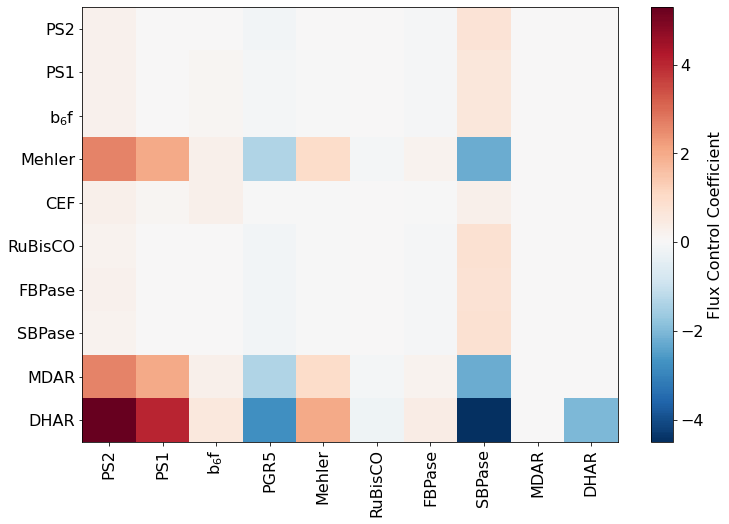

In [51]:
fsize = 16

elev_min=data.min()
elev_max=data.max()
mid_val=0

#plt.grid(None)

fig, ax = plt.subplots(figsize=(12,8))
ax.grid(None)
im = ax.imshow(data,interpolation='nearest', aspect='auto', cmap='RdBu_r',clim=(elev_min, elev_max), norm=MidpointNormalize(midpoint=mid_val,vmin=elev_min, vmax=elev_max))

# We want to show all ticks...
ax.set_xticks(np.arange(len(scanparnames)))
ax.set_yticks(np.arange(len(freadoutnames)))
# ... and label them with the respective list entries
ax.set_xticklabels(scanparnames,fontsize=fsize,rotation=90)
ax.set_yticklabels(freadoutnames,fontsize=fsize)
cbar = fig.colorbar(im,ax=ax,label='Flux Control Coefficient')
#plt.savefig("Users/nima/FCC.svg")

cbar.ax.tick_params(labelsize=fsize)
cbar.set_label(label="Flux Control Coefficient", fontsize=fsize)

#plt.show()

In [52]:
fig.savefig("FCC1000.eps")

In [53]:
creadouts=["PQ_redoxstate","Fd_redoxstate","PC_redoxstate","NADP_redoxstate","ATP_norm","RUBP","PGA","FBP","SBP"]
creadoutnames=["PQ$_\mathrm{red}$","Fd$_\mathrm{red}$","PC$_\mathrm{red}$","NADPH","ATP","RUBP","PGA","FBP","SBP"]

In [54]:
cdata = np.array(ccc.loc[creadouts,scanpars])
cdata.min()

-1.8883159867209547

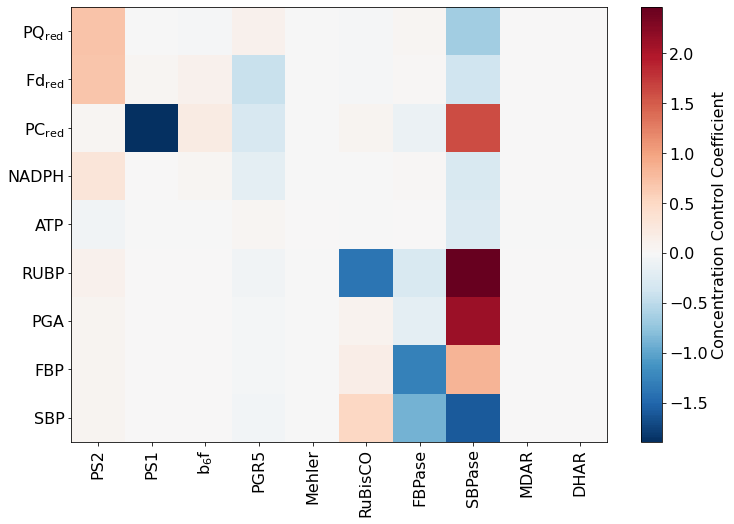

In [55]:

elev_min=cdata.min()
elev_max=cdata.max()
mid_val=0

#plt.grid(None)

fig, ax = plt.subplots(figsize=(12,8))
ax.grid(None)
im = ax.imshow(cdata,interpolation='nearest', aspect='auto', cmap='RdBu_r',clim=(elev_min, elev_max), norm=MidpointNormalize(midpoint=mid_val,vmin=elev_min, vmax=elev_max))

# We want to show all ticks...
ax.set_xticks(np.arange(len(scanparnames)))
ax.set_yticks(np.arange(len(creadoutnames)))
# ... and label them with the respective list entries
ax.set_xticklabels(scanparnames,fontsize=fsize, rotation=90)
ax.set_yticklabels(creadoutnames,fontsize=fsize)
cbar = fig.colorbar(im,ax=ax,label='Concentration Control Coefficient')
#plt.savefig("Users/nima/FCC.svg")

cbar.ax.tick_params(labelsize=fsize)
cbar.set_label(label="Concentration Control Coefficient", fontsize=fsize)


#plt.show()

### control coefficients for low light (PPFD=100)

In [18]:
s.update_parameter("pfd",100)

In [19]:
fccdict = {}
cccdict = {}
for p in tqdm(scanpars, total=len(scanpars)):
    crc, frc = response_coefficients(s,p)
    fccdict[p] = frc
    cccdict[p] = crc

fcc = pd.DataFrame(fccdict)
ccc = pd.DataFrame(cccdict)

  0%|          | 0/10 [00:00<?, ?it/s]

In [20]:
fcc.loc[freadouts,scanpars]

,PSIItot,PSItot,kCytb6f,kcyc,kMehler,V1_base,V6_base,V9_base,kcat_DHAR,kcatMDAR
vPS2,0.501871,0.516224,0.009520,-0.056932,0.000041,0.000733,-0.000584,0.018095,-1.216964e-12,-3.162450e-12
vPS1,0.360269,0.610964,0.011305,0.027416,-0.000035,-0.000196,0.001104,-0.005317,1.522684e-12,-6.018800e-12
vB6f,0.360269,0.610964,0.011305,0.027416,-0.000035,-0.000196,0.001104,-0.005317,1.504700e-12,-5.976836e-12
vMehler,0.240942,1.568327,-0.421823,-0.344110,0.999860,-0.001351,0.003313,-0.034486,5.575119e-12,-1.801766e-11
vCyc,0.039988,0.778679,0.014492,0.244464,-0.000230,-0.002576,0.005509,-0.065316,8.236534e-12,-1.054781e-11
vRuBisCO,0.514239,0.614979,0.011383,-0.046666,-0.000044,0.001992,-0.008663,0.057655,1.512575e-12,-2.277173e-12
vFBPase,0.554776,0.668060,0.012365,-0.048623,-0.000046,0.001286,0.047083,-0.001237,1.663903e-12,-3.757556e-12
v9,0.514239,0.614979,0.011383,-0.046666,-0.000044,0.001992,-0.008663,0.057655,1.508419e-12,-2.250163e-12
vMDAreduct,0.240942,1.568326,-0.421823,-0.344110,0.999860,-0.001351,0.003313,-0.034486,5.573890e-12,4.947165e-07
vDHAR,0.460662,3.161115,-0.843382,-0.668141,2.000021,-0.002583,0.006331,-0.065904,3.183302e-08,-2.000690e+00


In [21]:
data = np.array(fcc.loc[freadouts,scanpars])
data.max()

3.1611145272484285

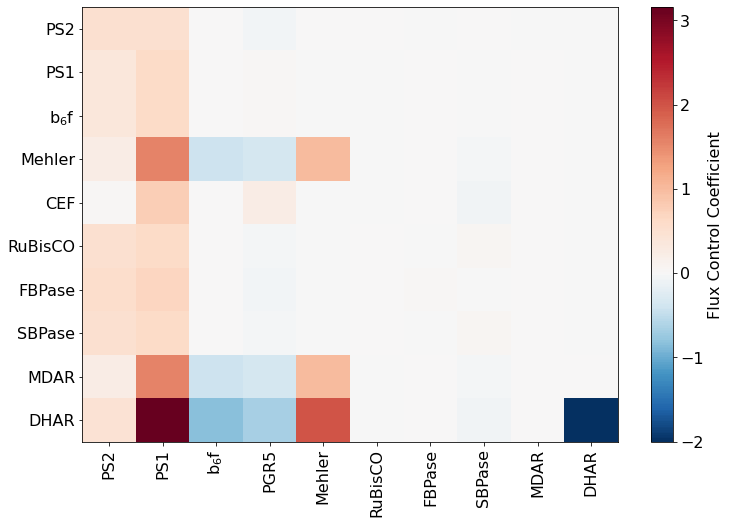

In [22]:
fsize = 16

elev_min=data.min()
elev_max=data.max()
mid_val=0

#plt.grid(None)

fig, ax = plt.subplots(figsize=(12,8))
ax.grid(None)
im = ax.imshow(data,interpolation='nearest', aspect='auto', cmap='RdBu_r',clim=(elev_min, elev_max), norm=MidpointNormalize(midpoint=mid_val,vmin=elev_min, vmax=elev_max))

# We want to show all ticks...
ax.set_xticks(np.arange(len(scanparnames)))
ax.set_yticks(np.arange(len(freadoutnames)))
# ... and label them with the respective list entries
ax.set_xticklabels(scanparnames,fontsize=fsize,rotation=90)
ax.set_yticklabels(freadoutnames,fontsize=fsize)
cbar = fig.colorbar(im,ax=ax,label='Flux Control Coefficient')
#plt.savefig("Users/nima/FCC.svg")

cbar.ax.tick_params(labelsize=fsize)
cbar.set_label(label="Flux Control Coefficient", fontsize=fsize)

#plt.show()

In [23]:
cdata = np.array(ccc.loc[creadouts,scanpars])
cdata.min()

-1.4940783344599127

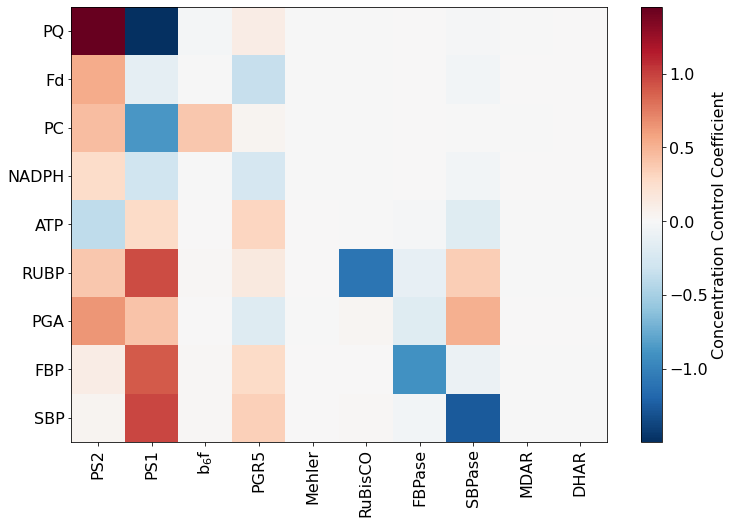

In [24]:

elev_min=cdata.min()
elev_max=cdata.max()
mid_val=0

#plt.grid(None)

fig, ax = plt.subplots(figsize=(12,8))
ax.grid(None)
im = ax.imshow(cdata,interpolation='nearest', aspect='auto', cmap='RdBu_r',clim=(elev_min, elev_max), norm=MidpointNormalize(midpoint=mid_val,vmin=elev_min, vmax=elev_max))

# We want to show all ticks...
ax.set_xticks(np.arange(len(scanparnames)))
ax.set_yticks(np.arange(len(creadoutnames)))
# ... and label them with the respective list entries
ax.set_xticklabels(scanparnames,fontsize=fsize, rotation=90)
ax.set_yticklabels(creadoutnames,fontsize=fsize)
cbar = fig.colorbar(im,ax=ax,label='Concentration Control Coefficient')
#plt.savefig("Users/nima/FCC.svg")

cbar.ax.tick_params(labelsize=fsize)
cbar.set_label(label="Concentration Control Coefficient", fontsize=fsize)


#plt.show()

### control coefficients for high light and impaired RuBisCO (PPFD=1000, V1_base * 0.25)

In [25]:
s.update_parameters({"pfd":1000,"V1_base":par_orig["V1_base"]/4})

In [26]:
fccdict = {}
cccdict = {}
for p in tqdm(scanpars, total=len(scanpars)):
    crc, frc = response_coefficients(s,p)
    fccdict[p] = frc
    cccdict[p] = crc

fcc = pd.DataFrame(fccdict)
ccc = pd.DataFrame(cccdict)

  0%|          | 0/10 [00:00<?, ?it/s]

In [27]:
fcc.loc[freadouts,scanpars]

,PSIItot,PSItot,kCytb6f,kcyc,kMehler,V1_base,V6_base,V9_base,kcat_DHAR,kcatMDAR
vPS2,0.128245,0.014487,0.003419,-0.096991,0.002609,0.721535,-0.027315,0.065419,1.835781e-12,7.560152e-11
vPS1,0.109382,0.034747,0.012483,-0.066273,-0.003580,0.658416,-0.018451,0.057567,2.237933e-12,5.900058e-11
vB6f,0.109382,0.034747,0.012483,-0.066273,-0.003580,0.658416,-0.018451,0.057567,1.939151e-12,5.911189e-11
vMehler,3.076738,1.549718,0.077535,-2.297645,0.941420,-1.385167,0.110577,-0.144684,5.624721e-11,1.648905e-09
vCyc,0.065546,0.084933,0.035001,0.012339,-0.019060,0.485815,0.004220,0.036610,3.283716e-12,1.966138e-11
vRuBisCO,0.111753,0.006683,0.003066,-0.086467,-0.002218,0.771987,-0.031128,0.086495,2.216135e-12,6.585086e-11
vFBPase,0.124223,0.007432,0.003409,-0.096116,-0.002462,0.835195,0.011827,0.036968,2.467709e-12,7.355273e-11
v9,0.111753,0.006683,0.003066,-0.086467,-0.002218,0.771987,-0.031128,0.086495,2.228311e-12,6.533945e-11
vMDAreduct,3.076545,1.549621,0.077531,-2.297501,0.941361,-1.385081,0.110571,-0.144675,5.627440e-11,1.211983e-04
vDHAR,6.359213,3.203452,0.160122,-4.748380,1.946312,-2.860049,0.228305,-0.298687,1.239237e-10,-2.067610e+00


In [28]:
data = np.array(fcc.loc[freadouts,scanpars])
data.max()

6.359212705666191

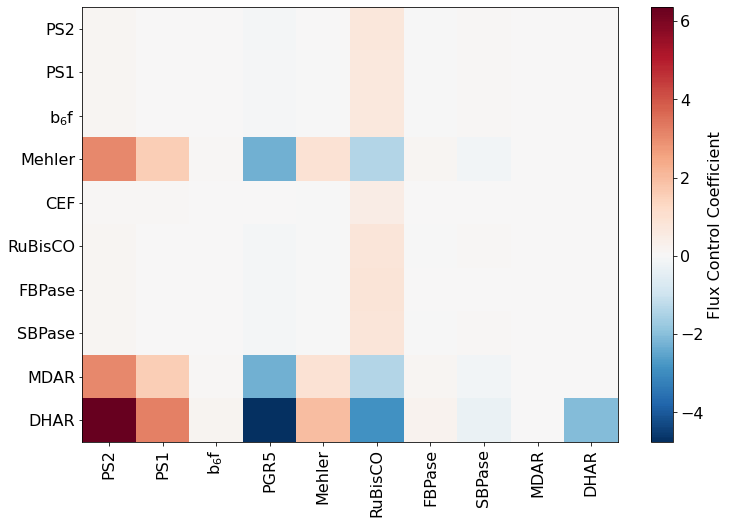

In [29]:
fsize = 16

elev_min=data.min()
elev_max=data.max()
mid_val=0

#plt.grid(None)

fig, ax = plt.subplots(figsize=(12,8))
ax.grid(None)
im = ax.imshow(data,interpolation='nearest', aspect='auto', cmap='RdBu_r',clim=(elev_min, elev_max), norm=MidpointNormalize(midpoint=mid_val,vmin=elev_min, vmax=elev_max))

# We want to show all ticks...
ax.set_xticks(np.arange(len(scanparnames)))
ax.set_yticks(np.arange(len(freadoutnames)))
# ... and label them with the respective list entries
ax.set_xticklabels(scanparnames,fontsize=fsize,rotation=90)
ax.set_yticklabels(freadoutnames,fontsize=fsize)
cbar = fig.colorbar(im,ax=ax,label='Flux Control Coefficient')
#plt.savefig("Users/nima/FCC.svg")

cbar.ax.tick_params(labelsize=fsize)
cbar.set_label(label="Flux Control Coefficient", fontsize=fsize)

#plt.show()

In [30]:
cdata = np.array(ccc.loc[creadouts,scanpars])
cdata.min()

-2.4103060299641075

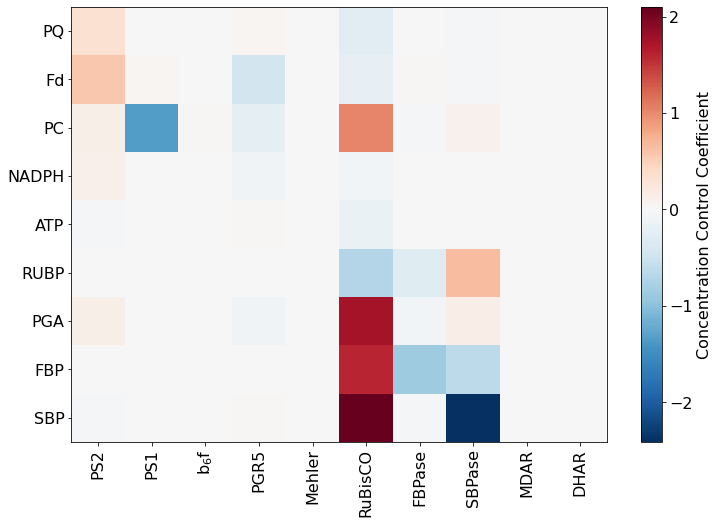

In [31]:

elev_min=cdata.min()
elev_max=cdata.max()
mid_val=0

#plt.grid(None)

fig, ax = plt.subplots(figsize=(12,8))
ax.grid(None)
im = ax.imshow(cdata,interpolation='nearest', aspect='auto', cmap='RdBu_r',clim=(elev_min, elev_max), norm=MidpointNormalize(midpoint=mid_val,vmin=elev_min, vmax=elev_max))

# We want to show all ticks...
ax.set_xticks(np.arange(len(scanparnames)))
ax.set_yticks(np.arange(len(creadoutnames)))
# ... and label them with the respective list entries
ax.set_xticklabels(scanparnames,fontsize=fsize, rotation=90)
ax.set_yticklabels(creadoutnames,fontsize=fsize)
cbar = fig.colorbar(im,ax=ax,label='Concentration Control Coefficient')
#plt.savefig("Users/nima/FCC.svg")

cbar.ax.tick_params(labelsize=fsize)
cbar.set_label(label="Concentration Control Coefficient", fontsize=fsize)


#plt.show()